# Botryllus brain analysis2
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
file_path = "../ci_brain_dec2023_counts_brain.txt"  # Update if needed
df = pd.read_csv(file_path, sep="\t")

# Pre_Processing

In [5]:
main_columns = [col for col in df.columns if col not in ["V1", "V2"]]

new_column_names = []
for col in main_columns:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[3]  # ILWXYZ (Sample ID)
        region = parts[5]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if parts[12].isdigit() and parts[13] == "months":
            age = f"{parts[12]}_{parts[13]}"  # "19_months"
            replicate = parts[9]  # Replicate (pXXcXXrXX)
            sample_number = parts[14]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-4] if len(parts) > 4 else "Unknown"
            sample_number = parts[-3] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# Rename columns in DataFrame
df.columns = ["Gene_ID", "Gene_Name"] + new_column_names
display(df.head())

,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,FUN_000001,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUN_000002,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,FUN_000003,NaN,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
3,FUN_000004,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FUN_000005,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)
- **File Type**: `.bam.counts` (Processed count file)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [6]:
# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_ID'].isna().sum()

print(f"Number of NaN values in 'Gene_ID': {nan_count}")

# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_Name'].isna().sum()

print(f"Number of NaN values in 'Gene_Name': {nan_count/df.shape[0]}")
# Check for duplicate Gene_IDs
gi_duplicates = df['Gene_ID'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
print(f"Duplicate values in 'Gene_ID': {gi_duplicates}")
print(f"Duplicate values in 'Gene_Name': {gene_name_duplicates}")
# Create a mapping from old Gene_ID to new format
df = df.iloc[:-5]
df['Gene_ID'] = df['Gene_ID'].str.extract(r'(\d+)').astype(str)  # Extract numbers
df['Gene_ID'] = 'g' + df['Gene_ID'].astype(str)  # Convert to 'g1', 'g2', etc.
df['Gene_ID'] = df['Gene_ID'].str.replace(r'g0*', 'g', regex=True)
df['Gene_Name'].fillna(df['Gene_ID'], inplace=True)
df["g_unique"] = df["Gene_ID"] + "_" + df["Gene_Name"]
first_col = df.pop('g_unique')  # Remove the column and store it
df.insert(0, 'g_unique', first_col)

display(df.head(3))

# set GI as index
df.set_index('Gene_ID', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]
print(df.shape, df_cleaned.shape)

display(df_cleaned.head())

# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.head()



Number of NaN values in 'Gene_ID': 0
Number of NaN values in 'Gene_Name': 0.7462666547438076
Duplicate values in 'Gene_ID': False
Duplicate values in 'Gene_Name': True


,g_unique,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,g1_g1,g1,g1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2_DNAJB11_1,g2,DNAJB11_1,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,g3_g3,g3,g3,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0


(44727, 685) (44727, 685)


,g_unique,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1,g1_g1,g1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2,g2_DNAJB11_1,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3,g3_g3,g3,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
g4,g4_g4,g4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5,g5_SMU1,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,ILW101-B2-19_months-p06c09r03-S513,ILW101-B2-19_months-p06c01r05-S529,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1_g1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2_DNAJB11_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3_g3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,10,0,0,0,0,0
g4_g4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5_SMU1,0,0,0,0,0,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0


**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [7]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW100-B2-19_months-p05c01r01-S385',
       'ILW100-B2-19_months-p05c05r02-S401',
       'ILW100-B2-19_months-p05c09r03-S417',
       'ILW100-B2-19_months-p05c01r05-S433'],
      dtype='object')
Index(['g1_g1', 'g2_DNAJB11_1', 'g3_g3', 'g4_g4'], dtype='object')
(683, 44727)


In [8]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [9]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 44727)


**Check** the format of the matrix

In [10]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [12]:
import scanpy as sc  # Ensure scanpy is imported

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

/tmp/ipykernel_20286/1097839567.py:4: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [13]:
print(adata.obs.shape)

(581, 7)


In [14]:
# Zeros fraction
zeros_perGene_frac = np.sum(adata.X == 0, axis=0) / adata.X.shape[0]

genes_above = zeros_perGene_frac[zeros_perGene_frac > 0.95]
num_genes_above = len(genes_above)/adata.X.shape[1]
print("Number of genes with a fraction of zeros above :", num_genes_above)

# plt.figure(figsize=(6,3))
# sns.histplot(zeros_perGene_frac, bins=80, color='skyblue', stat='density')
# plt.xlim(0.85,1)



Number of genes with a fraction of zeros above : 0.38449993177786873


In [15]:
print(adata.shape)

(581, 14658)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [16]:
# Step 1: Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Logarithmize the data log(x+1)
sc.pp.log1p(adata)



# PCA

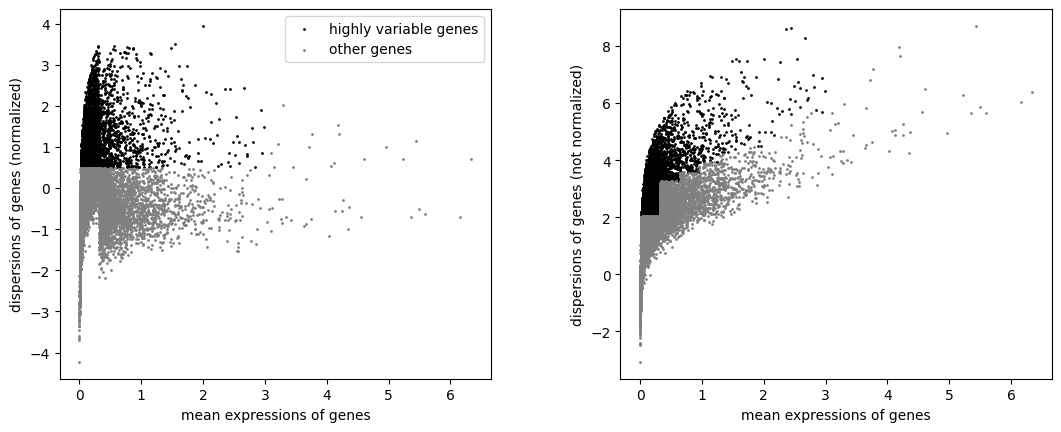

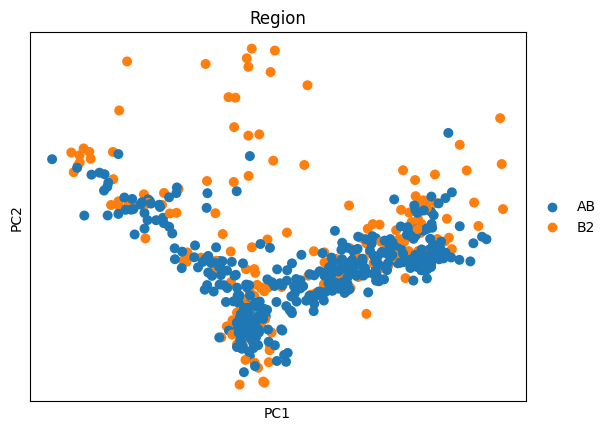

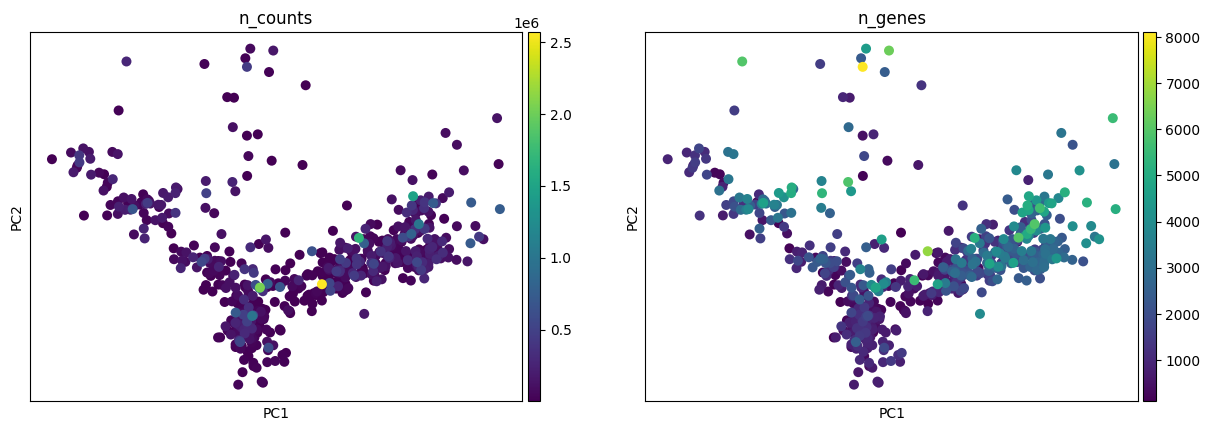

In [17]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

# Run PCA using HVGs
sc.tl.pca(adata, svd_solver = 'arpack', use_highly_variable=True)

# Plot PCA
sc.pl.pca(adata, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata, color=['n_counts', 'n_genes'])

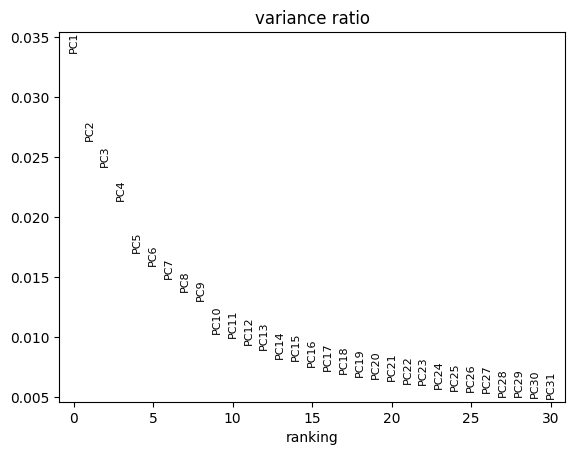

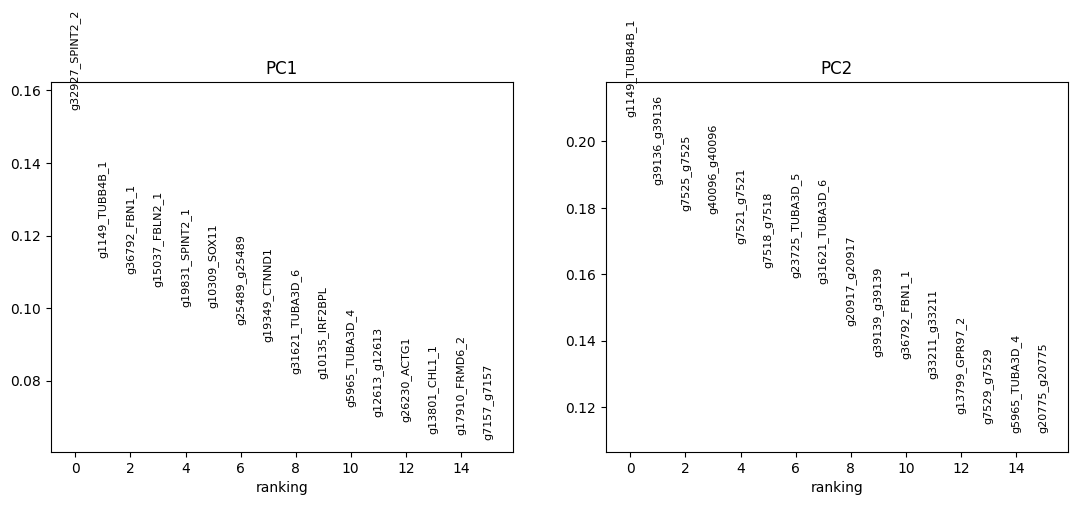

In [18]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata, log=False)

# PCA loadings (genes contributing to PCs)
sc.pl.pca_loadings(adata, components='1,2', show=False, include_lowest=False, n_points=15)

# Dimensionality Reduction UMAP


## umap(nn=25,npcs=5,metrics=cosine)

For each cell, look at the first 6 PCA dimensions, and find the 25 most similar cells using cosine distance.

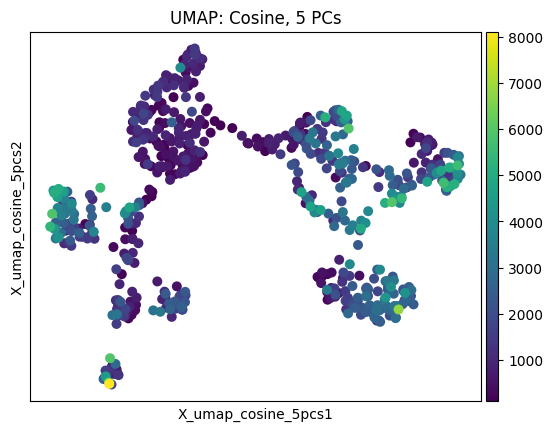

In [83]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='cosine')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_cosine_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph
adata.uns['neighbors_cosine_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_cosine_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_cosine_5pcs'] = adata.obsp['distances'].copy()

# Plot it
sc.pl.embedding(adata, basis='X_umap_cosine_5pcs', color='n_genes', title='UMAP: Cosine, 5 PCs')

## umap(nn=25,npcs=5,metrics=euclidean)

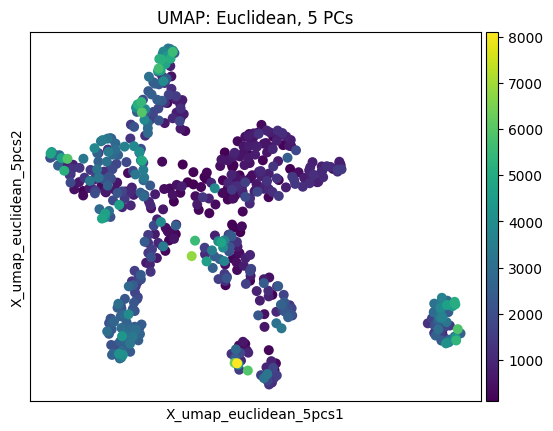

In [69]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='euclidean')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_euclidean_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph (optional but useful)
adata.uns['neighbors_euclidean_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_euclidean_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_euclidean_5pcs'] = adata.obsp['distances'].copy()

# Plot UMAP
sc.pl.embedding(adata, basis='X_umap_euclidean_5pcs', color='n_genes', title='UMAP: Euclidean, 5 PCs')



In [20]:
# # Restore cosine neighbors if you want to cluster using that graph again
# adata.uns['neighbors'] = adata.uns['neighbors_cosine_6pcs']
# adata.obsp['connectivities'] = adata.obsp['connectivities_cosine_6pcs']
# adata.obsp['distances'] = adata.obsp['distances_cosine_6pcs']

# # Then you can run clustering (e.g. Leiden)
# sc.tl.leiden(adata, resolution=0.5)
# sc.pl.embedding(adata, basis='X_umap_cosine_6pcs', color='leiden')


## Save UMAP

In [21]:
# adata.write('my_analysis_with_multiple_umaps.h5ad')

# Clustering (Leiden and DBSCAN) 

The two best parameters for each umap is defined in the code

In [88]:
import scanpy as sc
from sklearn.cluster import DBSCAN

def run_umap_and_cluster(
    adata,
    nn,
    npcs,
    metric,
    leiden_resolution=0.58,
    dbscan_eps=0.5,
    dbscan_min_samples=5
):
    # Step 1: Compute neighbors
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=npcs, metric=metric, random_state=0)
    
    # Step 2: Compute UMAP
    sc.tl.umap(adata)
    
    # Save UMAP embedding with flag in obsm
    umap_key = f'X_umap_nn{nn}_pcs{npcs}_{metric}'
    adata.obsm[umap_key] = adata.obsm['X_umap'].copy()
    
    # Step 3: Leiden clustering
    leiden_key = f'leiden_res{leiden_resolution}_nn{nn}_pcs{npcs}_{metric}'
    sc.tl.leiden(adata, resolution=leiden_resolution, key_added=leiden_key)
    
    # Step 4: DBSCAN clustering on the UMAP embedding
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric=metric)
    dbscan_labels = dbscan.fit_predict(adata.obsm[umap_key])
    dbscan_key = f'dbscan_eps{dbscan_eps}_min{dbscan_min_samples}_nn{nn}_pcs{npcs}_{metric}'
    adata.obs[dbscan_key] = dbscan_labels.astype(str)
    
    # Return keys for later use
    return {
        'umap_key': umap_key,
        'leiden_key': leiden_key,
        'dbscan_key': dbscan_key
    }


## Heatmap


Processing clustering: leiden_res0.5_nn25_pcs5_cosine


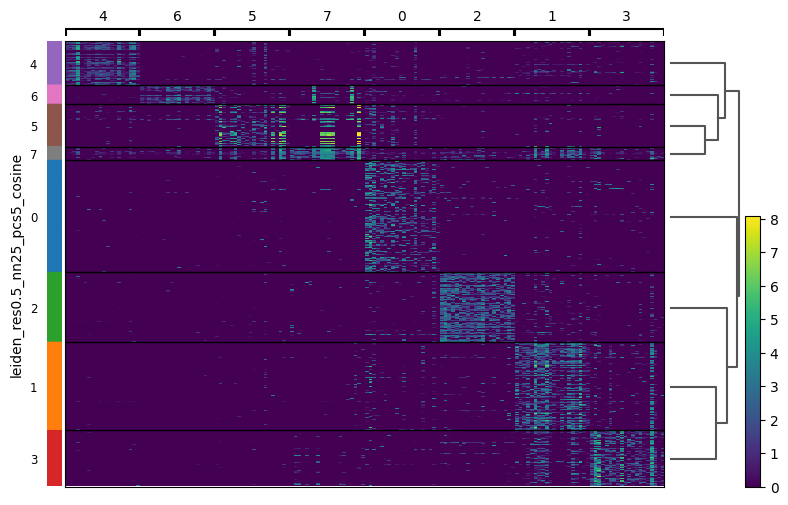


Processing clustering: leiden_res0.5_nn25_pcs5_euclidean


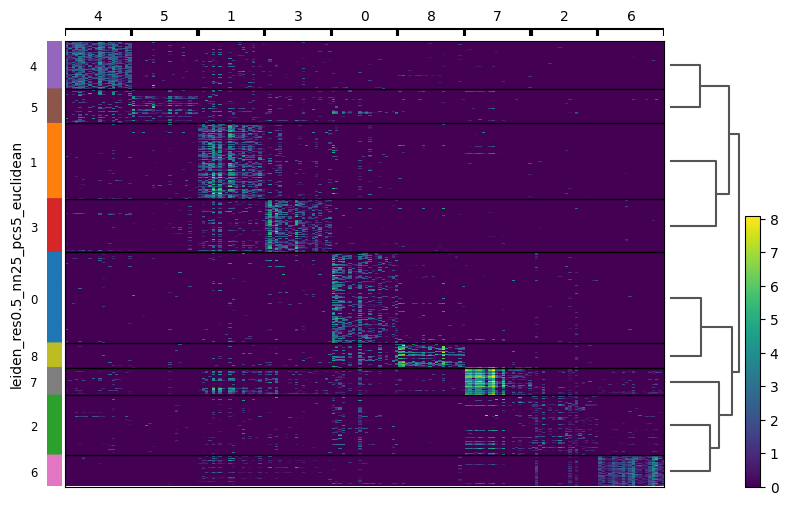

In [157]:
clusterings = [
    'leiden_res0.5_nn25_pcs5_cosine',
    'leiden_res0.5_nn25_pcs5_euclidean'
]

for clust_key in clusterings:
    print(f"\nProcessing clustering: {clust_key}")
    
    # Rank genes per cluster (Wilcoxon)
    sc.tl.rank_genes_groups(
        adata,
        groupby=clust_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=f'wilcoxon_{clust_key}'
    )
    
    # Plot heatmap of top 20 marker genes
    sc.pl.rank_genes_groups_heatmap(
        adata,
        n_genes=20,
        groupby=clust_key,
        key=f'wilcoxon_{clust_key}',
        show=True
    )


In [155]:
results_cosine = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=5,
    metric='cosine',
    leiden_resolution=0.58,
    dbscan_eps=0.00045,
    dbscan_min_samples=5
)

results_euclidean = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=7,
    metric='euclidean',
    leiden_resolution=0.5,
    dbscan_eps=0.6,
    dbscan_min_samples=5
)


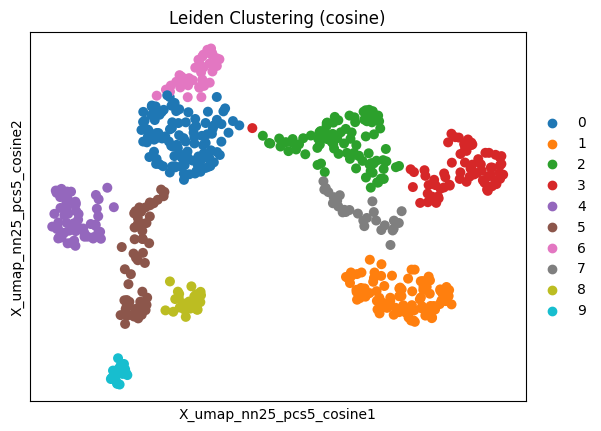

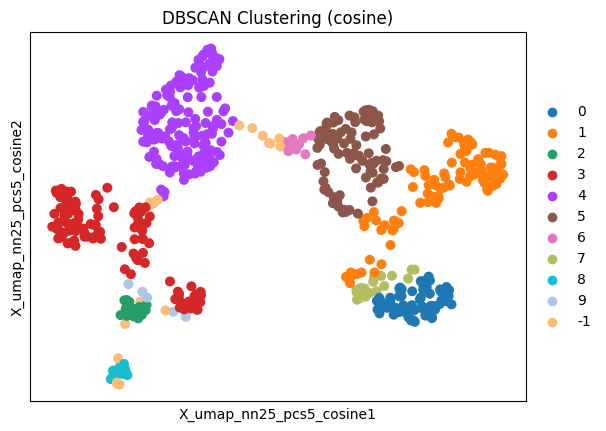

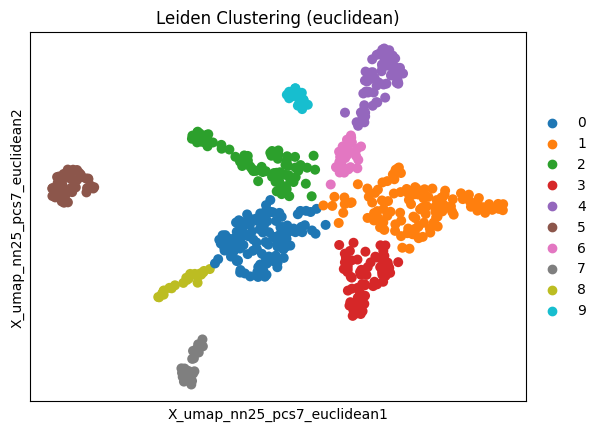

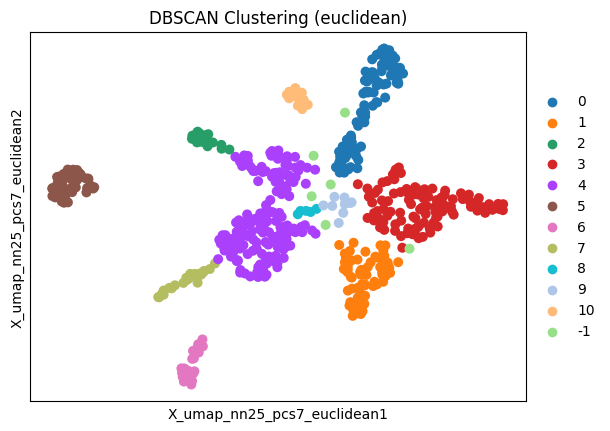

In [156]:
# Plot UMAP colored by Leiden for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['leiden_key'], title='Leiden Clustering (cosine)')

# Plot UMAP colored by DBSCAN for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['dbscan_key'], title='DBSCAN Clustering (cosine)')

# Plot UMAP colored by Leiden for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['leiden_key'], title='Leiden Clustering (euclidean)')

# Plot UMAP colored by DBSCAN for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['dbscan_key'], title='DBSCAN Clustering (euclidean)')


# Marker gene finding

## Finding the marker genes in each cluster

In [182]:
def extract_suffix(s):
    parts = s.split('_')
    return parts[1] if len(parts) > 1 else s

In [183]:
# Toggle which clustering results you want to process
# Just comment out the ones you don't want

cluster_keys = [
    # 'leiden_res0.5_nn25_pcs5_cosine',
    'leiden_res0.5_nn25_pcs5_euclidean',
    # 'dbscan_eps0.8_min5_nn25_pcs5_cosine',
    # 'dbscan_eps0.5_min5_nn25_pcs5_euclidean'
]

In [ ]:
# # === FLAGS ===
# RUN_RANKING = True
# SAVE_CSV = True
# TOP_N = 300   # Set to None to disable top-N trimming
# PRINT_PREVIEW = True

# # === Loop through your clustering keys ===
# for cluster_key in cluster_keys:
#     print(f"\nProcessing: {cluster_key}")
    
#     marker_key = f'wilcoxon_{cluster_key}'
    
#     if RUN_RANKING:
#         # Run Wilcoxon ranking
#         sc.tl.rank_genes_groups(
#             adata,
#             groupby=cluster_key,
#             method='wilcoxon',
#             tie_correct=True,
#             pts=True,
#             key_added=marker_key
#         )
    
#     # Extract results
#     result = adata.uns[marker_key]
#     groups = result['names'].dtype.names  # cluster names

#     # Collect marker genes per cluster (optionally trim to top N)
#     marker_df = pd.concat([
#         pd.DataFrame({
#             'cluster': group,
#             'gene': result['names'][group][:TOP_N] if TOP_N else result['names'][group],
#             'score': result['scores'][group][:TOP_N] if TOP_N else result['scores'][group],
#             'logfoldchange': result['logfoldchanges'][group][:TOP_N] if TOP_N else result['logfoldchanges'][group],
#             'pval': result['pvals'][group][:TOP_N] if TOP_N else result['pvals'][group],
#             'pval_adj': result['pvals_adj'][group][:TOP_N] if TOP_N else result['pvals_adj'][group],
#             'pct_expr': result['pts'][group][:TOP_N] if TOP_N else result['pts'][group]
#         })
#         for group in groups
#     ])

#     # Save to CSV if enabled
#     if SAVE_CSV:
#         filename = f'top{TOP_N if TOP_N else "all"}_marker_genes_{cluster_key}.csv'
#         marker_df.to_csv(filename, index=False)
#         print(f"Saved: {filename}")
    
#     # Print preview if enabled
#     if PRINT_PREVIEW:
#         print(marker_df.head())


In [184]:
for cluster_key in cluster_keys:
    print(f"\nProcessing: {cluster_key}")
    
    marker_key = f'wilcoxon_{cluster_key}'
    
    # Rank genes using Wilcoxon test
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=marker_key
    )
    
    # Extract full result: names, scores, logfoldchanges, pvals, etc.
    result = adata.uns[marker_key]
    groups = result['names'].dtype.names  # cluster names

    full_marker_df = pd.concat([
        pd.DataFrame({
            'cluster': group,
            'gene': result['names'][group],
            'score': result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'pct_expr': result['pts'][group]
        })
        for group in groups
    ])

    # Save to CSV
    filename = f'marker_genes_{cluster_key}.csv'
    full_marker_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")



Processing: leiden_res0.5_nn25_pcs5_euclidean
Saved: marker_genes_leiden_res0.5_nn25_pcs5_euclidean.csv


In [185]:
full_marker_df.head(10)

,cluster,gene,score,logfoldchange,pval,pval_adj,pct_expr
g3_g3,0,g29898_g29898,12.567969,4.504480,3.167573e-36,4.643029e-32,0.076271
g4_g4,0,g19347_g19347,12.418319,4.419445,2.078843e-35,1.523584e-31,0.008475
g5_SMU1,0,g26701_g26701,10.944500,4.032496,7.060616e-28,3.449817e-24,0.008475
g6_LYPLAL1,0,g9451_MEOX2,10.253323,3.177891,1.143445e-24,3.352124e-21,0.016949
g9_ADPRHL2_1,0,g28412_g28412,9.684511,4.705459,3.508824e-22,3.956334e-19,0.016949
g13_g13,0,g12560_g12560,9.604086,3.712307,7.683661e-22,6.625124e-19,0.474576
g15_g15,0,g38261_g38261,9.110224,6.667074,8.221197e-20,4.463196e-17,0.016949
g18_g18,0,g30908_g30908,9.050015,4.039415,1.429479e-19,6.984435e-17,0.016949
g20_SUDS3_1,0,g12632_g12632,8.979869,2.931535,2.710885e-19,1.135319e-16,0.000000
g21_ARMC1_1,0,g13439_g13439,8.494942,3.303005,1.980321e-17,5.609687e-15,0.016949


## Finding the marker genes (Only annotated markers)

In [186]:
# === Choose which clustering result to process ===
# Just comment/uncomment
marker_key = f'wilcoxon_{cluster_key}'

# === Extract & clean marker gene info ===
names_raw = pd.DataFrame(adata.uns[marker_key]['names']).applymap(extract_suffix)

# Remove unannotated (e.g. "g123") gene names
names_clean = names_raw.applymap(lambda x: None if isinstance(x, str) and x.startswith('g') and x[1:].isdigit() else x)

# Drop clusters with no annotated markers
names_df = names_clean.dropna(axis=1, how='all').copy()

# Get log fold changes and p-values
lfc_df = pd.DataFrame(adata.uns[marker_key]['logfoldchanges'])
lfc_df.columns = [f"{c}_logFC" for c in lfc_df.columns]

pval_df = pd.DataFrame(adata.uns[marker_key]['pvals'])
pval_df.columns = [f"{c}_pval" for c in pval_df.columns]

# === Combine into a single DataFrame ===
out = pd.DataFrame()
for cl in names_df.columns:
    mask = names_df[cl].notna()
    genes = names_df.loc[mask, cl].reset_index(drop=True)
    logs  = lfc_df.loc[mask, f"{cl}_logFC"].reset_index(drop=True)
    pvs   = pval_df.loc[mask, f"{cl}_pval"].reset_index(drop=True)

    out[cl] = genes
    out[f"{cl}_logFC"] = logs
    out[f"{cl}_pval"] = pvs

# === Save to CSV with tag ===
# filename = f"annotated_marker_genes_{cluster_key}.csv"
# out.to_csv(filename, index=False)
# print(f"Saved annotated marker genes to: {filename}")
# print the head of the DataFrame
out.head(10)

,0,0_logFC,0_pval,1,1_logFC,1_pval,2,2_logFC,2_pval,3,...,5_pval,6,6_logFC,6_pval,7,7_logFC,7_pval,8,8_logFC,8_pval
0,MEOX2,3.177891,1.143445e-24,SPON1,6.236715,2.153379e-52,SULT2B1,5.743980,4.469743e-20,TUBA3D,...,3.772789e-31,GPR20,9.701915,2.145209e-109,SPE1,8.693709,5.212754e-49,lon-1,9.248736,2.018697e-44
1,SPE1,3.439282,3.756286e-15,SLC51A,4.820904,1.934425e-51,GNAT2,3.891508,4.517585e-20,CCDC65,...,1.195433e-22,FAM26F,9.178346,1.955799e-99,fibcd1,6.087789,4.612032e-43,SSTR5,6.568782,6.157362e-40
2,RTP4,2.267022,1.972885e-13,FBN1,5.120023,9.097446e-46,NOS1,6.358007,8.695461e-20,ACTG1,...,3.674110e-19,MFAP4,8.470510,4.300301e-96,NPTX2,6.590270,9.073651e-36,Glipr1l1,10.258353,4.404497e-36
3,SULT1B1,5.632196,2.018095e-13,FBN1,4.677384,7.750484e-43,PPO1,5.823051,1.389339e-19,CIB1,...,7.657756e-18,hch-1,7.691256,6.386789e-82,CYP2R1,4.896123,1.711419e-30,PRY1,7.813419,1.326170e-32
4,SPE1,3.430818,2.248412e-13,SLC6A7,4.636238,4.791317e-39,SELENBP1,7.866922,9.922667e-18,FZD10,...,1.691738e-13,SERPINB8,9.126230,1.136618e-81,GPR64,4.626326,7.588153e-29,FGD2,10.693352,2.898503e-32
5,OPRL1,3.083852,8.275233e-13,MEP1B,4.340873,4.270560e-38,SLC5A5,5.150195,1.711600e-17,FOXQ1,...,8.405677e-13,FIBCD1,8.315787,1.110164e-76,SLC9B2,4.006143,3.775350e-28,EMX2,6.147655,6.018834e-28
6,GATA2,2.550448,3.657144e-11,foxh1,4.277491,6.019617e-38,4CL1,25.949202,1.972676e-17,KIF28P,...,9.566834e-13,ptpn9,7.373494,3.607785e-75,SSTR5,3.811068,1.452074e-25,MTNR1A,7.101831,1.184961e-26
7,ALOX12B,5.227310,7.444825e-10,SLC6A7,4.741832,2.233390e-37,SELENBP1,3.930700,4.128927e-17,DNAH9,...,1.927827e-12,GPR97,8.719790,4.728582e-72,DDRGK1,5.020388,4.531790e-24,SOX7,5.907545,1.862800e-22
8,OIT3,1.697706,1.067971e-09,COL2A1,4.477829,3.941093e-37,TSPAN9,2.313042,5.461335e-17,KIF9,...,2.686763e-12,PDPK1,5.380155,7.483694e-70,TMED4,5.888732,7.418590e-23,LRP5L,4.968293,1.187857e-21
9,SLC6A7,5.560105,4.204265e-09,GLI2,4.190595,8.770562e-35,SLC5A6,5.890337,1.627069e-16,NME8,...,2.651386e-11,CMD1,5.939350,7.374139e-68,TSPAN2,3.270261,2.187530e-22,SPTAN1,8.301657,3.835629e-21


## Finding the marker genes (Only annotated markers) just gene names

In [ ]:
# === Choose which clustering result to process ===
marker_key = f'wilcoxon_{cluster_key}'

# === Extract and clean gene names ===
import re

def extract_suffix(gene_id):
    """Extract gene name from gID_GeneName and remove suffixes like _1, _2."""
    if isinstance(gene_id, str) and '_' in gene_id:
        gene_name = gene_id.split('_', 1)[1]
        # Remove trailing _1, _2, etc. if present (ASIC1_1 → ASIC1)
        return re.sub(r'_\d+$', '', gene_name)
    return gene_id


names_raw = pd.DataFrame(adata.uns[marker_key]['names']).applymap(extract_suffix)

# Remove unannotated gene names (e.g., "g123")
names_clean = names_raw.applymap(
    lambda x: None if isinstance(x, str) and x.startswith('g') and x[1:].isdigit() else x
)

# Drop clusters with no annotated genes
names_df = names_clean.dropna(axis=1, how='all').copy()

# === Build output with gene names only ===
out = pd.DataFrame()
for cl in names_df.columns:
    mask = names_df[cl].notna()
    genes = names_df.loc[mask, cl].reset_index(drop=True)
    out[cl] = genes

# # === Step 3: Keep only the first 300 non-null genes per cluster ===
# top_genes_per_cluster = pd.DataFrame()
# for col in names_clean.columns:
#     top_genes = names_clean[col].dropna().head(300).reset_index(drop=True)
#     top_genes_per_cluster[col] = top_genes

# === View or save ===
out.head(10)
# Optional: save to CSV
# out.to_csv(f"annotated_gene_names_only_{cluster_key}.csv", index=False)


,0,1,2,3,4,5,6,7,8
0,MEOX2,SPON1,SULT2B1,TUBA3D,SOGA1,COL6A2,GPR20,SPE1,lon-1
1,SPE1,SLC51A,GNAT2,CCDC65,EBF2,C1QTNF4,FAM26F,fibcd1,SSTR5
2,RTP4,FBN1,NOS1,ACTG1,FGF14,CNTN2,MFAP4,NPTX2,Glipr1l1
3,SULT1B1,FBN1,PPO1,CIB1,RGS3,MATN2,hch-1,CYP2R1,PRY1
4,SPE1,SLC6A7,SELENBP1,FZD10,NRXN2,TMPRSS6,SERPINB8,GPR64,FGD2
5,OPRL1,MEP1B,SLC5A5,FOXQ1,CPN1,CXCR6,FIBCD1,SLC9B2,EMX2
6,GATA2,foxh1,4CL1,KIF28P,ASIC1,TIMP3,ptpn9,SSTR5,MTNR1A
7,ALOX12B,SLC6A7,SELENBP1,DNAH9,NRXN2,LAMA2,GPR97,DDRGK1,SOX7
8,OIT3,COL2A1,TSPAN9,KIF9,CDH23,SMPDL3B,PDPK1,TMED4,LRP5L
9,SLC6A7,GLI2,SLC5A6,NME8,BIRC2,UNC80,CMD1,TSPAN2,SPTAN1
